# New York City Taxi Fare Prediction

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Carrega 2.500.000 linhas do dataset 
train_data = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 25000)
test_data = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')


## Definição do Desafio
A competição chamada “New York City Taxi Fare” foi realizada em parceria com o Google Cloud e a Coursera onde o objetivo é prever o valor de uma viagem de táxi dados os locais de origem e destino.

O conjunto de dados para treino consistem em aproximadamente 55 milhões de linhas com
valores de viagens em NYC.

A base de dados é composta pelos seguintes atributos:
* **key** - String única que identifica cada linha. É dada a partir da data e hora de embarque mais um inteiro único.
* **pickup_datetime** - data e horário de quando a viagem de táxi foi iniciada.
* **pickup_longitude** - float que representa a longitude de onde a viagem de táxi foi iniciada.
* **pickup_latitude** - float que representa a latitude de onde a viagem de táxi foi iniciada.
* **dropoff_longitude** - float que representa a longitude de onde a viagem de táxi foi terminada.
* **dropoff_latitude** - float que representa a latitude de onde a viagem de táxi foi terminada.
* **passenger_count** - inteiro que indica a quantidade de passageiros na viagem.


Dados que precisamos prever (target)
* **fare_amount** - valor flutuante em dólares do custo da corrida de táxi. Este valor está apenas no conjunto de treinamento; isso é o que você está prevendo no conjunto de teste e é exigido em seu CSV de envio.


## Pré-processamento
Como pré-processamento, fizemos a limpeza e redução dos dados, excluindo linhas que tenham informações de local (dropoff ou pickup) nulas, valores negativos, quantidades de passageiros inválidas e outliers.

### Limpeza e redução


In [2]:
# checando os tipos
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                25000 non-null  object 
 1   fare_amount        25000 non-null  float64
 2   pickup_datetime    25000 non-null  object 
 3   pickup_longitude   25000 non-null  float64
 4   pickup_latitude    25000 non-null  float64
 5   dropoff_longitude  25000 non-null  float64
 6   dropoff_latitude   25000 non-null  float64
 7   passenger_count    25000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB


In [3]:
# checando a existência de dados nulos
train_data.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [4]:
# excluindo linhas com coordenadas nulas
train_data.dropna(axis=0, subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
train_data.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [5]:
print("Corridas com custo negativo ou 0: " + str(len(train_data[train_data['fare_amount']<1])))
print("Corridas com mais de 6 passageiros: " + str(len(train_data[train_data['passenger_count']>6])))
print("Corridas com passageiros negativos ou 0: " + str(len(train_data[train_data['passenger_count']<1])))

Corridas com custo negativo ou 0: 5
Corridas com mais de 6 passageiros: 0
Corridas com passageiros negativos ou 0: 93


In [6]:
# removendo corridas com custo negativo ou zero, mais de 6 passageiros, passageiros negativos ou 0
train_data = train_data[(train_data.fare_amount > 0) & (train_data.passenger_count < 6) & (train_data.passenger_count > 0)]
train_data.shape

(24402, 8)

In [7]:
train_data.describe().round(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,24402.00,24402.00,24402.00,24402.00,24402.00,24402.00
mean,11.32,-72.51,39.94,-72.51,39.92,1.58
std,9.55,10.42,6.50,10.41,6.07,1.14
min,0.01,-75.41,-74.01,-84.65,-73.99,1.00
25%,6.00,-73.99,40.73,-73.99,40.73,1.00
50%,8.50,-73.98,40.75,-73.98,40.75,1.00
75%,12.50,-73.97,40.77,-73.96,40.77,2.00
max,180.00,40.77,401.08,40.80,41.37,5.00


### Outliers
Como consta no gráfico abaixo, observamos outliers que vamos retirar limitando o valor da corrida pra maior que 2.50 e menor que 600.

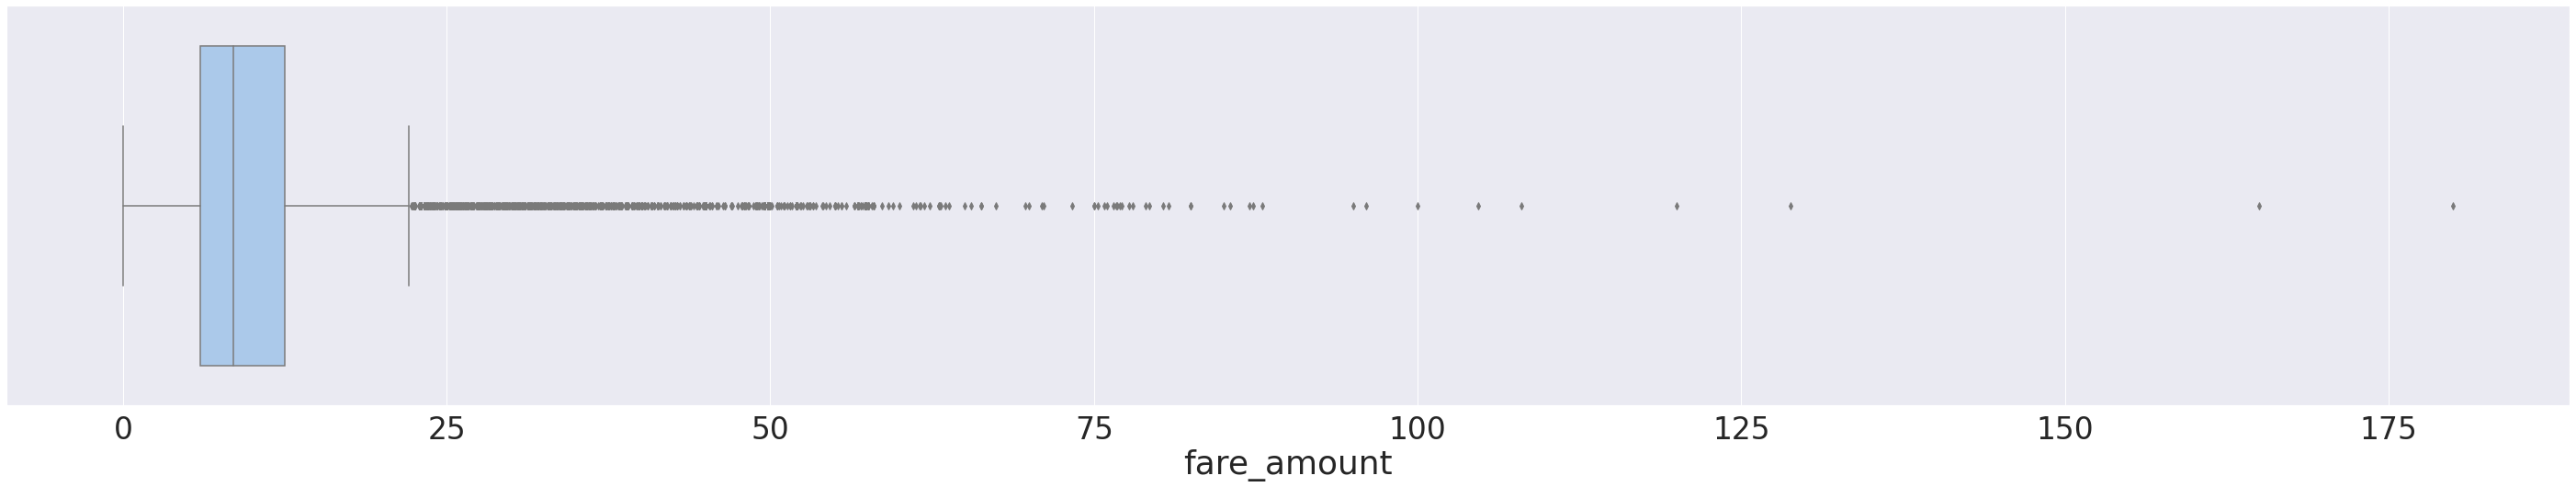

In [8]:
plt.figure(figsize=(50,8))
sns.set(font_scale=3)
sns.set_palette('pastel')
ax = sns.boxplot(x=train_data['fare_amount'])

In [9]:
train_data = train_data[(train_data.fare_amount > 2.50) & (train_data.fare_amount < 600) ]
train_data.shape

(24302, 8)

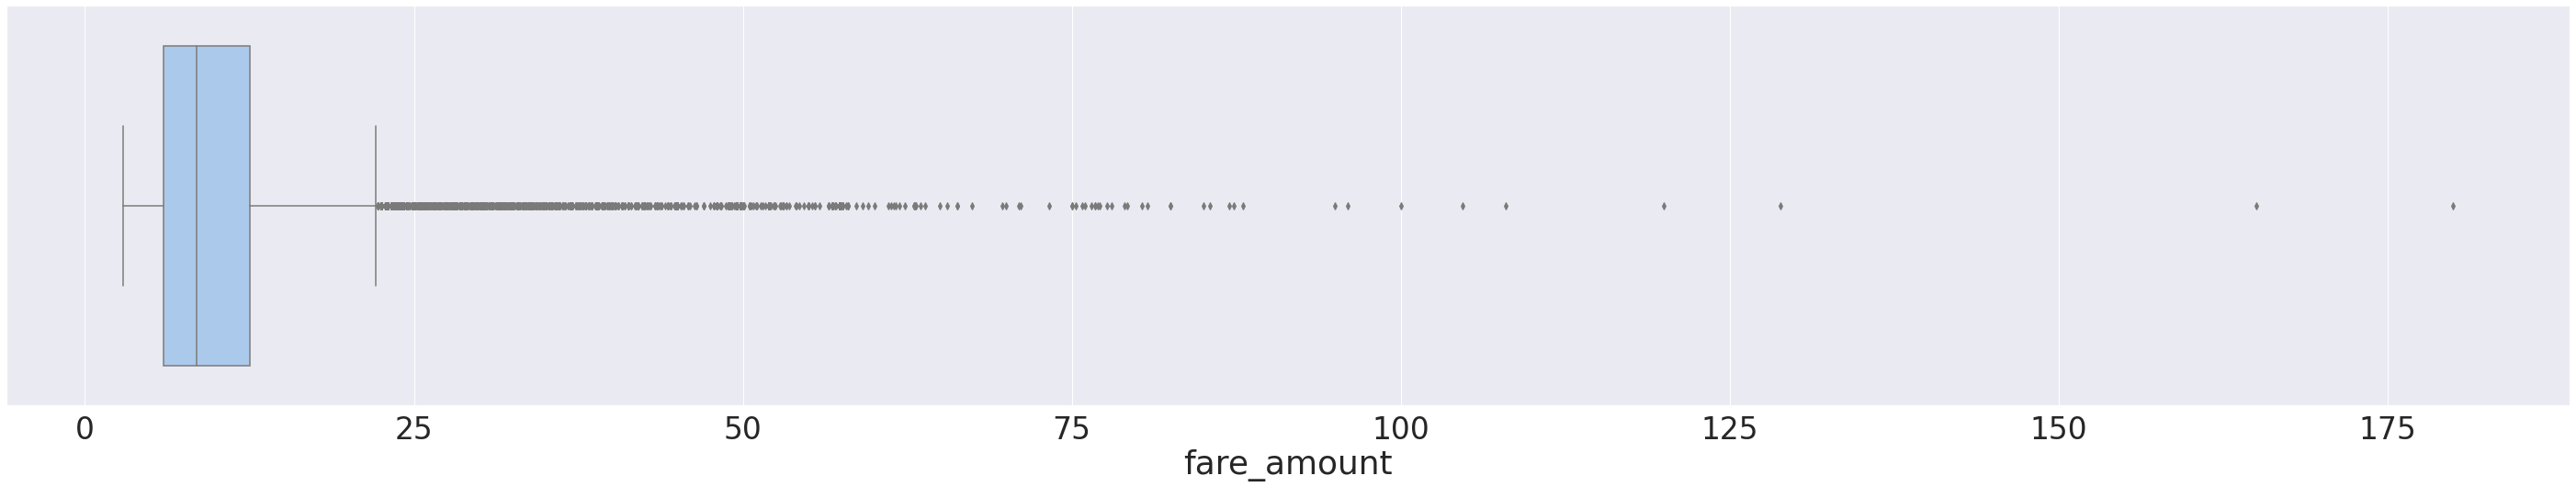

In [10]:
plt.figure(figsize=(50,8))
sns.set(font_scale=3)
sns.set_palette('pastel')
ax = sns.boxplot(x=train_data['fare_amount'])

Abaixo removemos corridas onde o ponto de partida ou de chegada não estão em NY, sendo que a cidade está com longitude entre -75 e -72 e latitude entre 40 e 42.

In [11]:
train_data = train_data[(train_data.pickup_longitude > -75) & (train_data.pickup_longitude < -72) &
                        (train_data.pickup_latitude > 40) & (train_data.pickup_latitude < 42) &
                        (train_data.dropoff_longitude > -75) & (train_data.dropoff_longitude < -72) &
                        (train_data.dropoff_latitude > 40) & (train_data.dropoff_latitude < 42) ]

# quantidade de linhas restantes após limpeza
train_data.shape

(23812, 8)

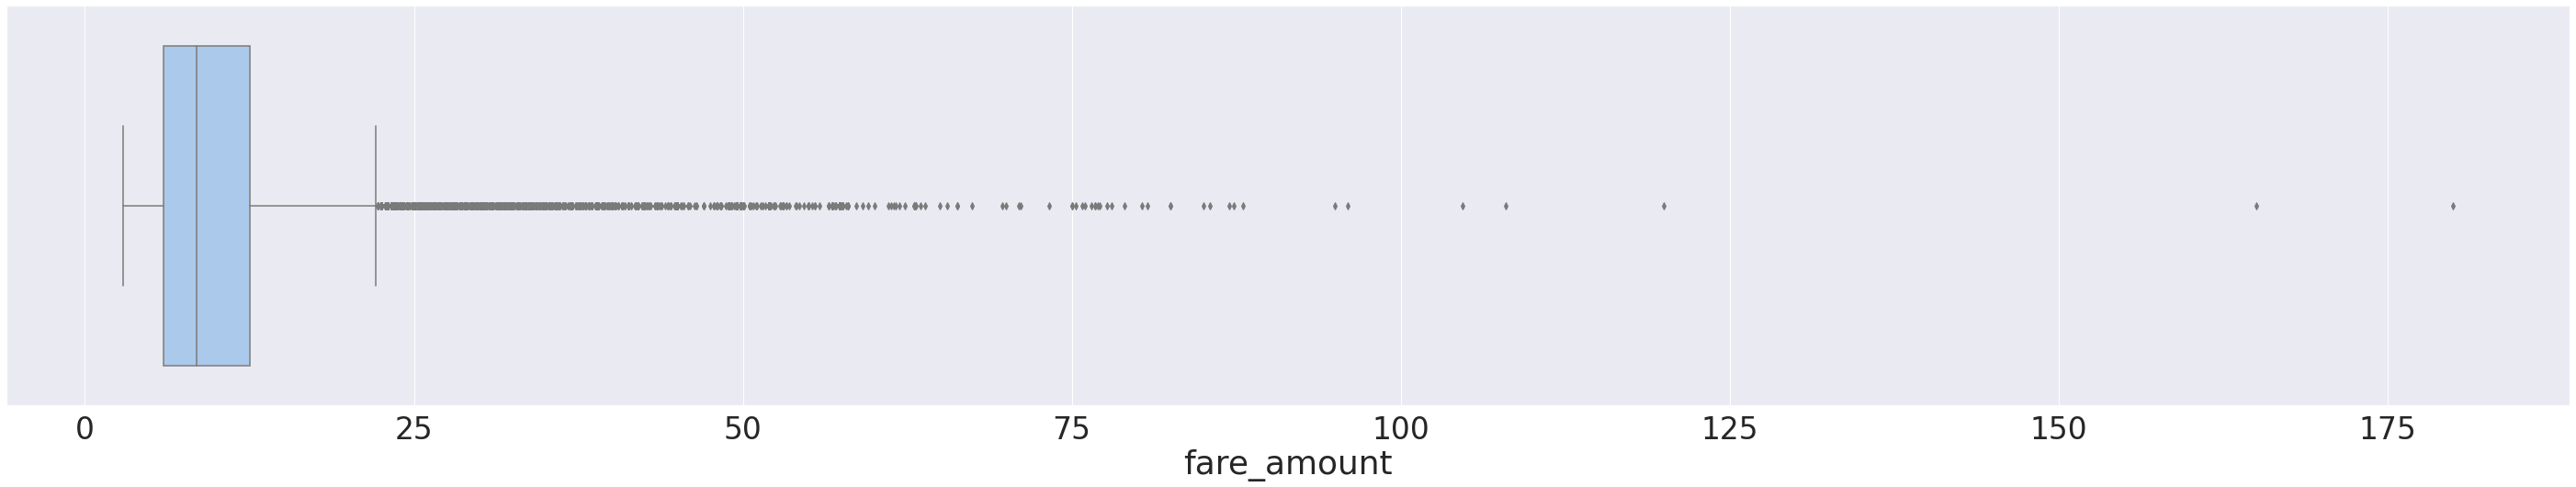

In [12]:
plt.figure(figsize=(50,8))
sns.set(font_scale=3)
sns.set_palette('pastel')
ax = sns.boxplot(x=train_data['fare_amount'])

In [13]:
test_data.shape

(9914, 7)

### Discretização

Para facilitar a análise dos dados, criamos algumas novas colunas com categorias novas, como:
* horário do dia (madrugada, manhã, tarde e noite)
* dia da semana (dia de semana, final de semana)

In [14]:
# função auxiliar para agrupar o horário do dia
def get_time_of_day(hour):
    if hour <= 5:
        return 'early_morning'
    if hour <= 12:
        return 'morning'
    if hour <= 18:
        return 'afternoon'
    if hour <= 23:
        return 'night'
    
# função auxiliar para agrupar o dia da semana
def get_weekday_type(weekday):
    if weekday in ['Saturday', 'Sunday']:
        return 'weekend'
    else:
        return 'workday'

    
# criando coluna com o horário e o dia da semana e ano
date_time_pickup = pd.to_datetime(train_data['pickup_datetime']).dt
train_data['time_of_day'] = date_time_pickup.hour.apply(get_time_of_day)
train_data['weekday'] = date_time_pickup.strftime("%A").apply(get_weekday_type)
train_data['year'] = date_time_pickup.year

date_time_pickup = pd.to_datetime(test_data['pickup_datetime']).dt
test_data['time_of_day'] = date_time_pickup.hour.apply(get_time_of_day)
test_data['weekday'] = date_time_pickup.strftime("%A").apply(get_weekday_type)
test_data['year'] = date_time_pickup.year

In [15]:
test_data.shape

(9914, 10)

### Transformação
Para facilitar a análise, adicionamos algumas colunas extras com informações relevantes. Foram elas:
* **manhattan_dist**: distância de manhattan entre o ponto de partida e chegada
* **km_dist**: distância em km entre o ponto de partida e chegada
* **fare_by_km**: valor pago por km naquela corrida

In [16]:
# função auxiliar para calcular a distância de manhattan
def get_manhattan_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return ((dropoff_long - pickup_long).abs() + (dropoff_lat - pickup_lat).abs())

def get_km_dist(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    pickup_lon, pickup_lat, dropoff_lon, dropoff_lat = map(np.radians, [pickup_lon, pickup_lat, dropoff_lon, dropoff_lat])
    dist_lon = dropoff_lon - pickup_lon
    dist_lat = dropoff_lat - pickup_lat
    a = np.sin(dist_lat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dist_lon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    km = 6367*c
    return km

# criando coluna com a distância
train_data['manhattan_dist'] = get_manhattan_dist(train_data.pickup_longitude, train_data.pickup_latitude, train_data.dropoff_longitude, train_data.dropoff_latitude)
test_data['manhattan_dist'] = get_manhattan_dist(test_data.pickup_longitude, test_data.pickup_latitude, test_data.dropoff_longitude, test_data.dropoff_latitude)
train_data['km_dist'] = get_km_dist(train_data.pickup_longitude, train_data.pickup_latitude, train_data.dropoff_longitude, train_data.dropoff_latitude).astype(np.float32)
test_data['km_dist'] = get_km_dist(test_data.pickup_longitude, test_data.pickup_latitude, test_data.dropoff_longitude, test_data.dropoff_latitude).astype(np.float32)
train_data = train_data[train_data.km_dist > 1]
#test_data = test_data[test_data.km_dist > 1]

# Cirando uma coluna valor por kilometro 
train_data['fare_by_km'] = (train_data['fare_amount']/train_data['km_dist']).round(2)


In [17]:
test_data.shape

(9914, 12)

## Análise Descritiva

Com os dados pré-processados, fizemos uma análise levando em consideração o valor da corrida por km.

<AxesSubplot:>

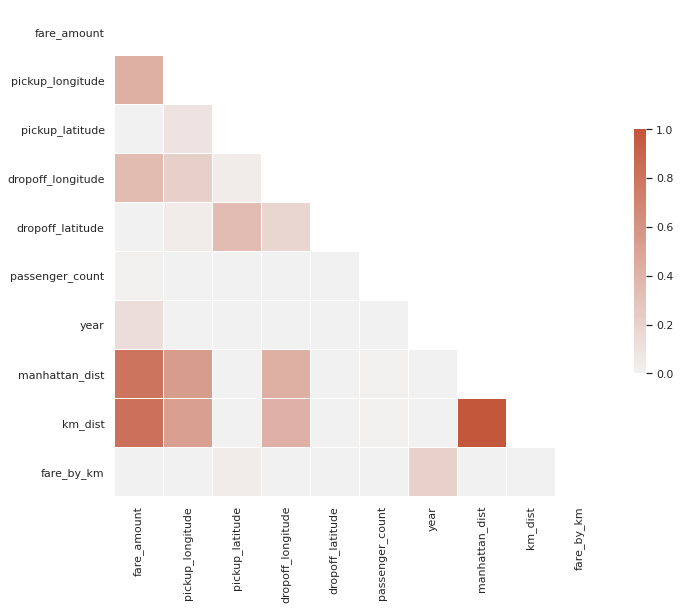

In [18]:
sns.set_theme(style="white")
sns.set_palette('pastel')


corr = train_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Média do valor por km para cada ano de viagem

Como mostrado no gráfico abaixo, podemos perceber que o preço do km aumentou um pouco com o passar dos anos.

Text(0.5, 1.0, 'Preço do km por ano')

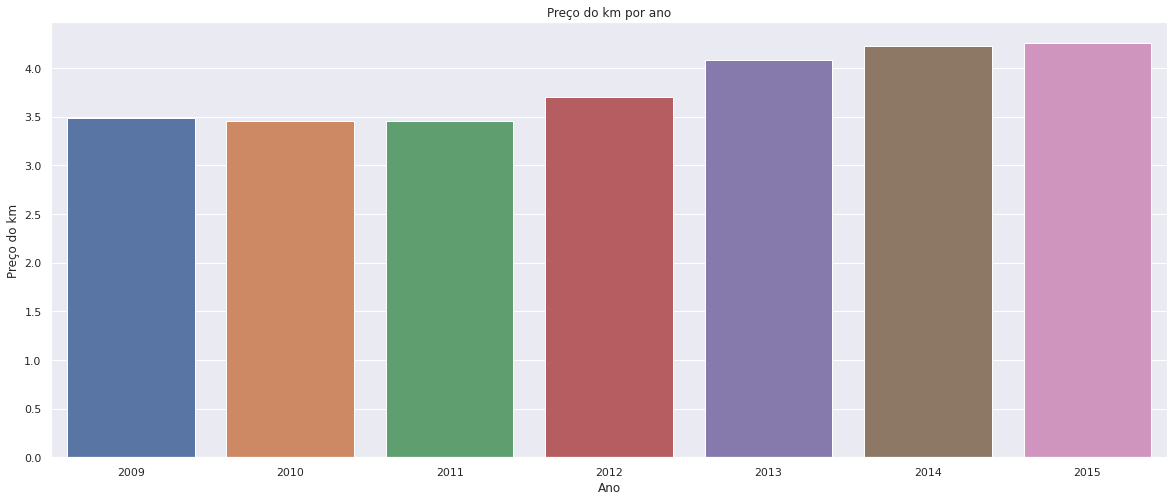

In [19]:
years = train_data['year'].unique()
means = []
for year in years:
    means.append(train_data.loc[train_data['year'] == year]['fare_by_km'].mean())
means

plt.figure(figsize=(20,8))
sns.set(font_scale=1)
ax = sns.barplot(x=years, y=means, data=train_data)
ax.set_xlabel('Ano')
ax.set_ylabel('Preço do km')
ax.set_title('Preço do km por ano')

### Média do valor por km para cada tipo de dia
Como podemos ver no gráfico abaixo, em média, o preço por km nos finais de semana foi um pouco menor que o preço durante os dias de semana.

Text(0.5, 1.0, 'Preço do km por dia da semana')

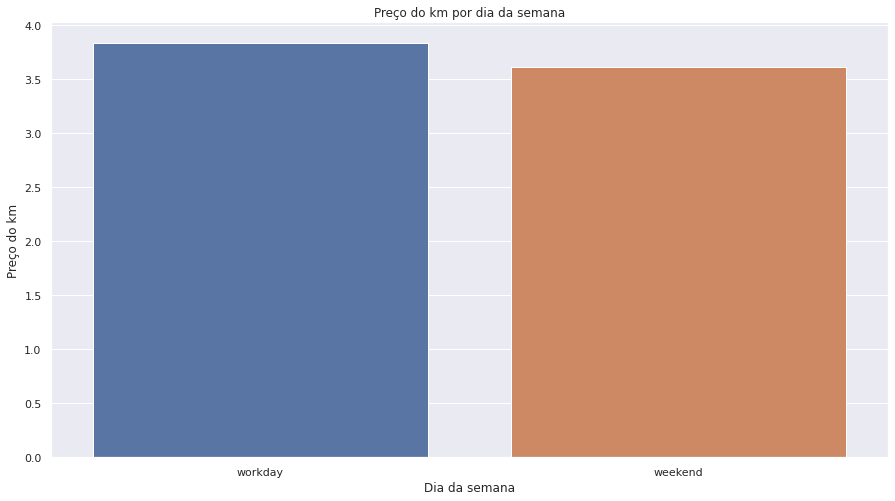

In [20]:
weekdays = train_data['weekday'].unique()
means = []
for weekday in weekdays:
    means.append(train_data.loc[train_data['weekday'] == weekday]['fare_by_km'].mean())
means

plt.figure(figsize=(15,8))
ax = sns.barplot(x=weekdays, y=means, data=train_data)
ax.set_xlabel('Dia da semana')
ax.set_ylabel('Preço do km')
ax.set_title('Preço do km por dia da semana')

### Média do valor por km para cada quantidade de passageiros

Pelo gráfico abaixo podemos ver que a quantidade de passageiros não influencia tanto no valor do km.

Text(0.5, 1.0, 'Preço do km por quantidade de passageiro')

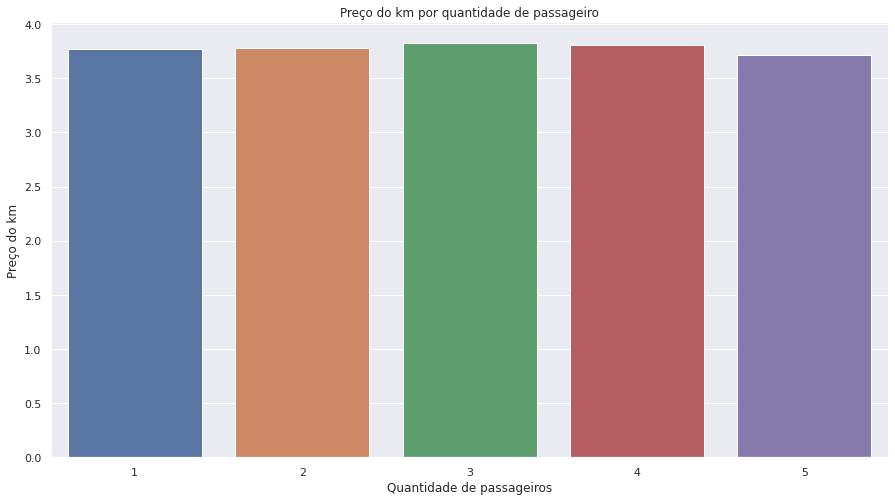

In [21]:
passangers = train_data['passenger_count'].unique()
means = []
for passanger in passangers:
    means.append(train_data.loc[train_data['passenger_count'] == passanger]['fare_by_km'].mean())
means

plt.figure(figsize=(15,8))
ax = sns.barplot(x=passangers, y=means, data=train_data)
ax.set_xlabel('Quantidade de passageiros')
ax.set_ylabel('Preço do km')
ax.set_title('Preço do km por quantidade de passageiro')

##  Predição do valor da corrida

Para predizer o valor da corrida, utilizamos três métodos de regreção para comparar a eficácia de cada um deles. Para comparação, utilizamos a métrica RMSE (root mean squared error), que é a medida que calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses). 

Podemos concluir que [...]

| Modelo | Regressão Linear | Random Forest | KNN    |
|--------|------------------|---------------|--------|
| RMSE   | 4.4181           | 1.0926        | 1.0926 |



In [22]:
col =  ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_by_km',
       'manhattan_dist']

train_data = train_data.drop(col, axis=1)
train_data = pd.get_dummies(train_data)
train_data.head()

,fare_amount,passenger_count,year,km_dist,time_of_day_afternoon,time_of_day_early_morning,time_of_day_morning,time_of_day_night,weekday_weekend,weekday_workday
0,4.5,1,2009,1.030117,1,0,0,0,0,1
1,16.9,1,2010,8.444828,1,0,0,0,0,1
2,5.7,2,2011,1.388653,0,1,0,0,0,1
3,7.7,1,2012,2.797513,0,1,0,0,1,0
4,5.3,1,2010,1.997902,0,0,1,0,0,1


In [23]:
teste_dados = test_data.copy()

col =  ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'manhattan_dist']

test_data = test_data.drop(col, axis=1)
test_data = pd.get_dummies(test_data)
test_data.head()

,passenger_count,year,km_dist,time_of_day_afternoon,time_of_day_early_morning,time_of_day_morning,time_of_day_night,weekday_weekend,weekday_workday
0,1,2015,2.321801,1,0,0,0,0,1
1,1,2015,2.423830,1,0,0,0,0,1
2,1,2011,0.618239,0,0,1,0,1,0
3,1,2012,1.959801,0,0,0,1,1,0
4,1,2012,5.383919,0,0,0,1,1,0


## **Normalização dos dados**


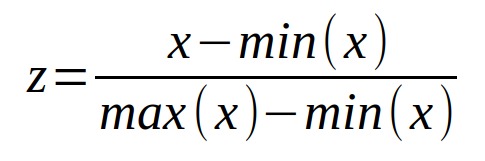

Normalização dos dados de traino

In [24]:
def normalize(value):
    return ((value - min(value))/ (max(value) - min(value)))

test_data['passenger_count'] = normalize(test_data['passenger_count'])
test_data['year'] = normalize(test_data['year'])
test_data['km_dist'] = normalize(test_data['km_dist'])
#train_data['fare_by_km'] = normalize(train_data['fare_by_km'])

In [25]:
test_data.head()

,passenger_count,year,km_dist,time_of_day_afternoon,time_of_day_early_morning,time_of_day_morning,time_of_day_night,weekday_weekend,weekday_workday
0,0.0,1.000000,0.023234,1,0,0,0,0,1
1,0.0,1.000000,0.024254,1,0,0,0,0,1
2,0.0,0.333333,0.006187,0,0,1,0,1,0
3,0.0,0.500000,0.019611,0,0,0,1,1,0
4,0.0,0.500000,0.053875,0,0,0,1,1,0


Normalização dos dados de treino

In [26]:
def normalize(value):
    return ((value - min(value))/ (max(value) - min(value)))

train_data['passenger_count'] = normalize(train_data['passenger_count'])
train_data['year'] = normalize(train_data['year'])
train_data['km_dist'] = normalize(train_data['km_dist'])

In [27]:
from sklearn.model_selection import train_test_split
X=train_data.drop(['fare_amount'],axis=1)
y=train_data['fare_amount']
# separando 25% dos dados pra validação
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=123)

## Modelos

In [28]:
# Regressão Linear

lm = LinearRegression()
lm.fit(X_train,y_train)
lm_pred = np.round(lm.predict(X_test),2)
lm_rmse = np.sqrt(mean_squared_error(lm_pred, y_test))
print("RMSE:", np.round(lm_rmse, 4))

result = pd.DataFrame({ 'fare_amount': y_test, 'predicted_fare_amount': lm_pred})
print(result)

RMSE: 5.8312
       fare_amount  predicted_fare_amount
12289          6.1                   5.93
10319          7.7                   7.09
18337         13.0                  13.15
24035         10.0                   9.33
17944          7.7                   9.21
...            ...                    ...
16083         10.5                  13.79
5272           5.7                   8.20
10842         19.5                  17.50
1051          36.1                  33.89
4431           7.3                   7.36

[4993 rows x 2 columns]


In [29]:
# Random Forest

rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred= np.round(rf.predict(X_test),2)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE", np.round(rf_rmse,4))

result = pd.DataFrame({ 'fare_amount': y_test, 'predicted_fare_amount': rf_pred})
print(result)

RMSE 4.4203
       fare_amount  predicted_fare_amount
12289          6.1                   5.41
10319          7.7                   7.25
18337         13.0                  16.55
24035         10.0                   8.52
17944          7.7                   9.62
...            ...                    ...
16083         10.5                  16.48
5272           5.7                   8.52
10842         19.5                  23.38
1051          36.1                  35.57
4431           7.3                   6.99

[4993 rows x 2 columns]


In [30]:
# KNN

knnR = KNeighborsRegressor()
knnR.fit(X_train, y_train)
knnR_pred= np.round(rf.predict(X_test),2)
knnR_rmse = np.sqrt(mean_squared_error(knnR_pred, y_test))
print("RMSE", np.round(knnR_rmse,4))

result = pd.DataFrame({ 'fare_amount': y_test, 'predicted_fare_amount': knnR_pred})
print(result)

RMSE 4.4203
       fare_amount  predicted_fare_amount
12289          6.1                   5.41
10319          7.7                   7.25
18337         13.0                  16.55
24035         10.0                   8.52
17944          7.7                   9.62
...            ...                    ...
16083         10.5                  16.48
5272           5.7                   8.52
10842         19.5                  23.38
1051          36.1                  35.57
4431           7.3                   6.99

[4993 rows x 2 columns]


In [31]:
teste_dados.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_of_day,weekday,year,manhattan_dist,km_dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,afternoon,workday,2015,0.028080,2.321801
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,afternoon,workday,2015,0.031841,2.423830
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,morning,weekend,2011,0.007991,0.618239
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,night,weekend,2012,0.025460,1.959801
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,night,weekend,2012,0.067867,5.383919


In [32]:
test_data.shape

(9914, 9)

In [33]:
submission = pd.DataFrame()
submission['key'] = teste_dados['key']
submission['fare_amount'] = np.round(rf.predict(test_data),2)

submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.78
1,2015-01-27 13:08:24.0000003,14.74
2,2011-10-08 11:53:44.0000002,7.20
3,2012-12-01 21:12:12.0000002,9.52
4,2012-12-01 21:12:12.0000003,19.38


In [34]:
submission.to_csv('sample_submission.csv', index=False)